In [1]:
!nvidia-smi

Sat Dec 13 21:56:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              1W /   75W |      93MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import Libraries
---

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU, Activation, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.utils import np_utils
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

import os
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

c:\Users\LEGION\anaconda3\envs\sentiment-analysis-dl\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [3]:
tf.__version__, np.__version__, pd.__version__, nltk.__version__, sklearn.__version__, hub.__version__

('2.10.1', '1.23.5', '2.0.3', '3.9.2', '1.2.2', '0.16.1')

In [4]:
RANDOM_SEED = 42

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stop_words = stopwords.words('english')
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

# Load dataset
---

dataset: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download

In [6]:
df = pd.read_csv('Hotel_Reviews.csv')
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


# EDA
---

In [7]:
f'{df.shape[0]} rows, {df.shape[1]} columns'

'515738 rows, 17 columns'

In [8]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Additional_Number_of_Scoring,515738.0,498.081836,500.538467,1.000000,169.000000,341.000000,660.000000,2682.000000
Average_Score,515738.0,8.397487,0.548048,5.200000,8.100000,8.400000,8.800000,9.800000
Review_Total_Negative_Word_Counts,515738.0,18.539450,29.690831,0.000000,2.000000,9.000000,23.000000,408.000000
Total_Number_of_Reviews,515738.0,2743.743944,2317.464868,43.000000,1161.000000,2134.000000,3613.000000,16670.000000
Review_Total_Positive_Word_Counts,515738.0,17.776458,21.804185,0.000000,5.000000,11.000000,22.000000,395.000000
Total_Number_of_Reviews_Reviewer_Has_Given,515738.0,7.166001,11.040228,1.000000,1.000000,3.000000,8.000000,355.000000
Reviewer_Score,515738.0,8.395077,1.637856,2.500000,7.500000,8.800000,9.600000,10.000000
lat,512470.0,49.442439,3.466325,41.328376,48.214662,51.499981,51.516288,52.400181
lng,512470.0,2.823803,4.579425,-0.369758,-0.143372,0.010607,4.834443,16.429233


In [11]:
df.describe(include='object').T

,count,unique,top,freq
Hotel_Address,515738,1493,163 Marsh Wall Docklands Tower Hamlets London ...,4789
Review_Date,515738,731,8/2/2017,2585
Hotel_Name,515738,1492,Britannia International Hotel Canary Wharf,4789
Reviewer_Nationality,515738,227,United Kingdom,245246
Negative_Review,515738,330011,No Negative,127890
Positive_Review,515738,412601,No Positive,35946
Tags,515738,55242,"[' Leisure trip ', ' Couple ', ' Double Room '...",5101
days_since_review,515738,731,1 days,2585


In [12]:
df.Reviewer_Score.describe()

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

Text(0.5, 1.0, 'Review Score Distribution')

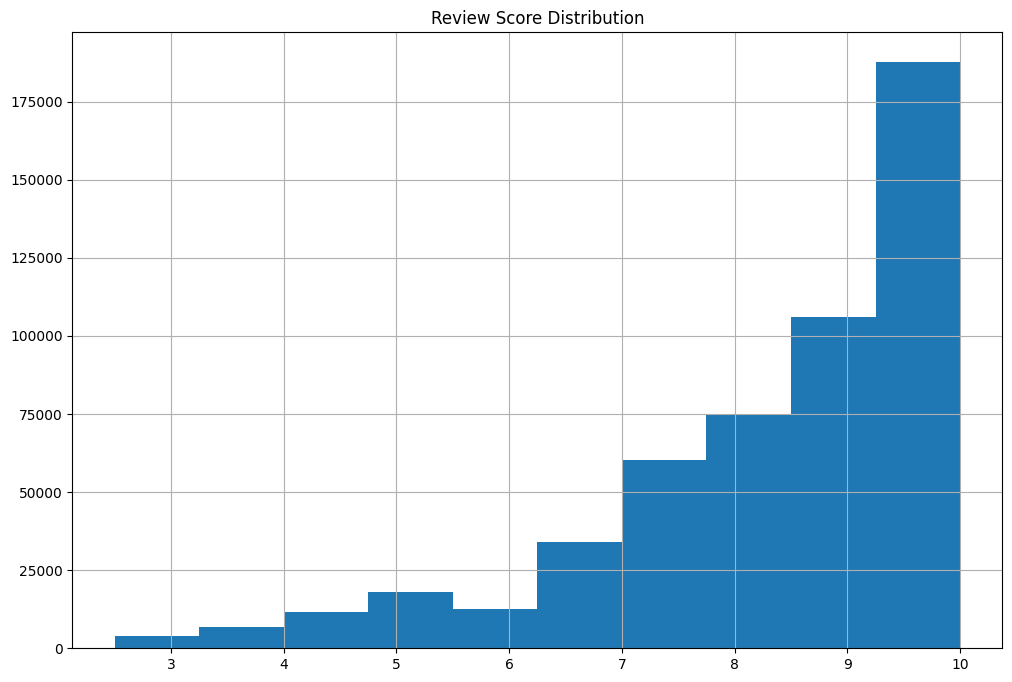

In [13]:
df.Reviewer_Score.hist()
plt.title('Review Score Distribution')

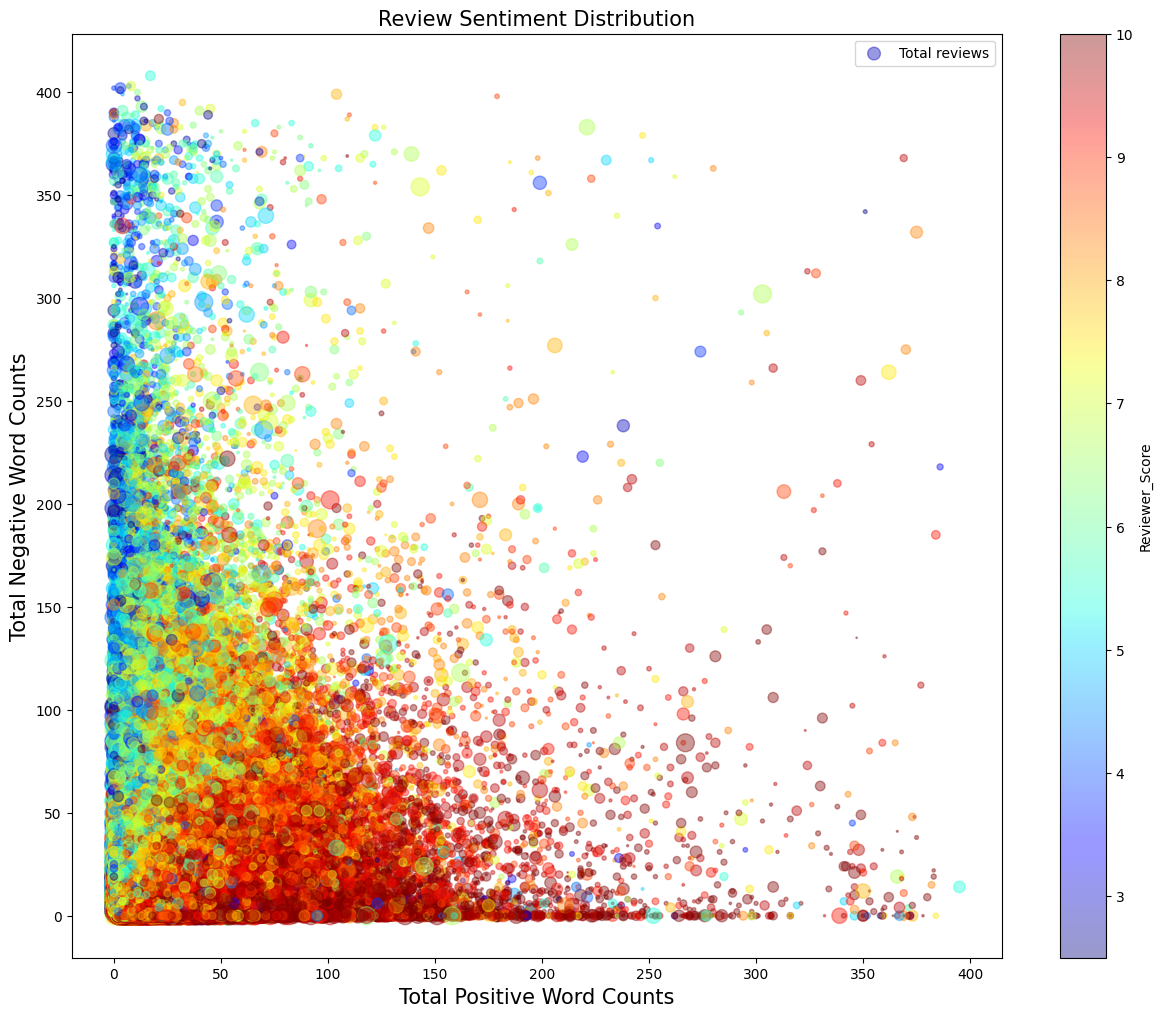

In [14]:
df.plot(kind='scatter', 
                      x='Review_Total_Positive_Word_Counts', 
                      y='Review_Total_Negative_Word_Counts', 
                      label='Total reviews',
             s=df.Total_Number_of_Reviews/100,
             c='Reviewer_Score',
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(15,12),
             sharex=False, 
             )
font_size = 15
plt.title("Review Sentiment Distribution",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()
     

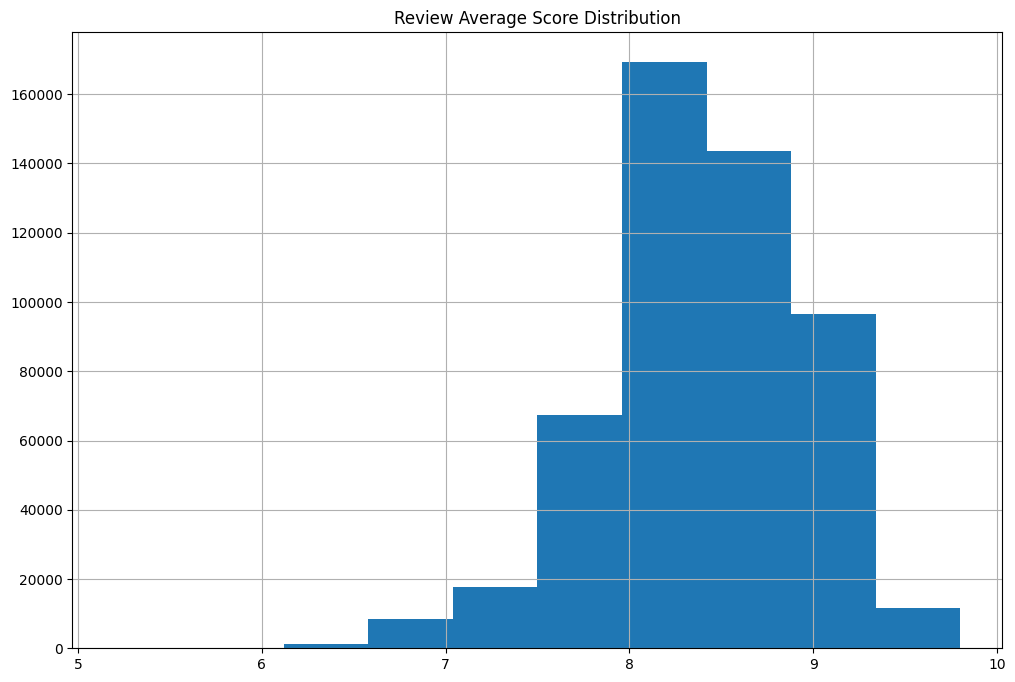

In [15]:
df.Average_Score.hist()
plt.title('Review Average Score Distribution');

## Clean Review Text

In [16]:
df.loc[df['Positive_Review'] == 'No Positive']

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
8,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/9/2017,7.7,Hotel Arena,Belgium,Even though the pictures show very clean room...,34,1403,No Positive,0,3,6.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",25 days,52.360576,4.915968
32,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/11/2017,7.7,Hotel Arena,United States of America,Our bathroom had an urine order Shower was ve...,68,1403,No Positive,0,1,4.2,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",84 days,52.360576,4.915968
98,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,9/19/2016,7.7,Hotel Arena,United Kingdom,Got charged 50 for a birthday package when it...,112,1403,No Positive,0,1,5.0,"[' Leisure trip ', ' Couple ', ' Large King Ro...",318 day,52.360576,4.915968
121,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,6/1/2016,7.7,Hotel Arena,United States of America,The first room had steep steps to a loft bed ...,39,1403,No Positive,0,12,8.3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",428 day,52.360576,4.915968
134,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/1/2016,7.7,Hotel Arena,Australia,Foyer was a mess Only place to relax was the ...,180,1403,No Positive,0,6,4.6,"[' Leisure trip ', ' Couple ', ' Duplex Double...",459 day,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515666,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,9/20/2016,8.1,Atlantis Hotel Vienna,Belgium,Noise from the air conditioning system imposs...,11,2823,No Positive,0,19,6.3,"[' Family with young children ', ' Family Room...",317 day,48.203745,16.335677
515688,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,7/11/2016,8.1,Atlantis Hotel Vienna,Romania,Parking to expensive and so is the breakfast,9,2823,No Positive,0,2,7.5,"[' Couple ', ' Standard Double or Twin Room ',...",388 day,48.203745,16.335677
515695,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,6/27/2016,8.1,Atlantis Hotel Vienna,South Korea,dust towel,3,2823,No Positive,0,2,7.1,"[' Leisure trip ', ' Solo traveler ', ' Standa...",402 day,48.203745,16.335677
515700,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,5/29/2016,8.1,Atlantis Hotel Vienna,Russia,Room vas located in different building with n...,25,2823,No Positive,0,2,3.8,"[' Business trip ', ' Solo traveler ', ' Stand...",431 day,48.203745,16.335677


In [17]:
df.loc[df['Negative_Review'] == 'No Negative']

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
13,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/4/2017,7.7,Hotel Arena,Italy,No Negative,0,1403,This hotel is being renovated with great care...,59,6,9.2,"[' Business trip ', ' Solo traveler ', ' Duple...",30 days,52.360576,4.915968
15,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/3/2017,7.7,Hotel Arena,Italy,No Negative,0,1403,This hotel is awesome I took it sincirely bec...,82,26,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",31 days,52.360576,4.915968
18,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,6/29/2017,7.7,Hotel Arena,Netherlands,No Negative,0,1403,Public areas are lovely and the room was nice...,33,4,7.1,"[' Business trip ', ' Group ', ' Duplex Double...",35 days,52.360576,4.915968
48,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,3/22/2017,7.7,Hotel Arena,United Kingdom,No Negative,0,1403,The quality of the hotel was brilliant and ev...,77,3,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",134 day,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515723,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,11/15/2015,8.1,Atlantis Hotel Vienna,Croatia,No Negative,0,2823,Second to none location if you re off to Stad...,23,1,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",627 day,48.203745,16.335677
515724,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,10/27/2015,8.1,Atlantis Hotel Vienna,India,No Negative,0,2823,Only location little far away from City,9,7,8.3,"[' Leisure trip ', ' Family with young childre...",646 day,48.203745,16.335677
515729,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,9/26/2015,8.1,Atlantis Hotel Vienna,Brazil,No Negative,0,2823,The breakfast was excelent lots of fress frui...,27,7,10.0,"[' Leisure trip ', ' Couple ', ' Standard Doub...",677 day,48.203745,16.335677
515732,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,9/6/2015,8.1,Atlantis Hotel Vienna,Kuwait,No Negative,0,2823,helpful staff allowed me to check in early as...,18,6,10.0,"[' Leisure trip ', ' Family with young childre...",697 day,48.203745,16.335677


In [18]:
df.loc[:, 'Positive_Review'] = df.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df.loc[:, 'Negative_Review'] = df.Negative_Review.apply(lambda x: x.replace('No Negative', ''))
     

In [19]:
df['Negative_Review'][1]

''

## Merge both review texts

In [20]:
df['Review'] = df.Positive_Review + df.Negative_Review

## Set Sentiment Types

In [21]:
df['Review_type'] = df['Reviewer_Score'].apply(lambda x: 'bad' if x < 7 else 'good')

In [22]:
df_reviews = df[['Review', 'Review_type']]

In [23]:
df_reviews.head(10)

,Review,Review_type
0,Only the park outside of the hotel was beauti...,bad
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,bad
5,Good restaurant with modern design great chil...,bad
6,The room is spacious and bright The hotel is ...,bad
7,Good location Set in a lovely park friendly s...,good
8,Even though the pictures show very clean room...,bad
9,The room was big enough and the bed is good T...,good


<Axes: >

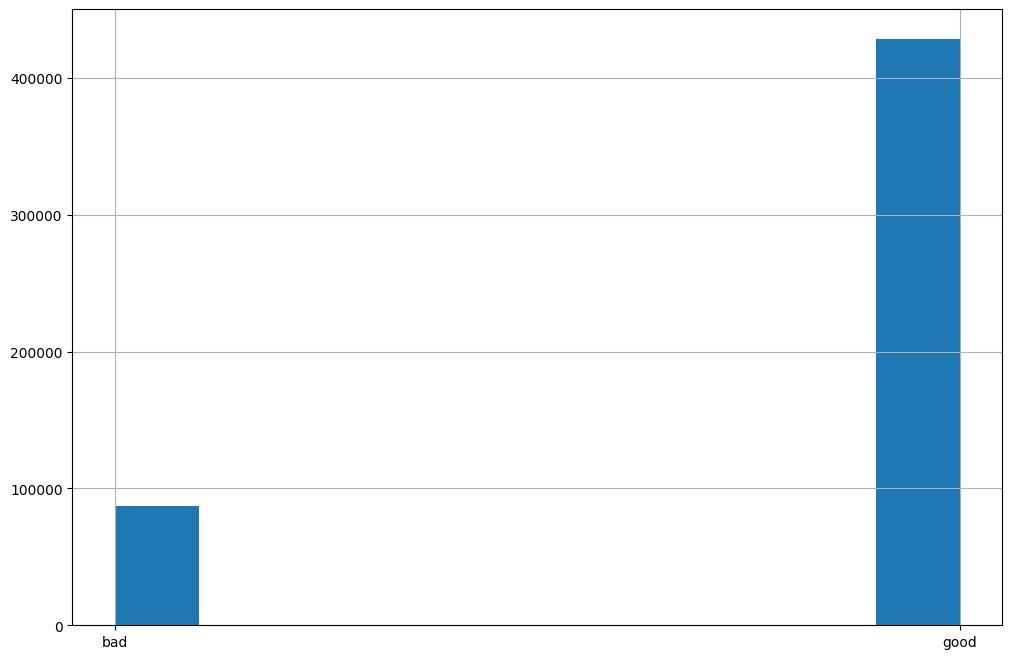

In [24]:
df_reviews.Review_type.hist()

In [25]:
df_reviews[df_reviews.Review_type == 'good'].Review.value_counts()

Review
 Location                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           947
 Everything Nothing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 938
 Everything      

In [26]:
df_reviews[df_reviews.Review_type == 'bad'].Review.value_counts()

Review
 Nothing Everything                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  124
 Location                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [27]:
good_reviews = df_reviews[df_reviews.Review_type == "good"]
bad_reviews = df_reviews[df_reviews.Review_type == "bad"]

In [28]:
good_reviews.head()

,Review,Review_type
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
7,Good location Set in a lovely park friendly s...,good
9,The room was big enough and the bed is good T...,good
10,Rooms were stunningly decorated and really sp...,good


In [29]:
bad_reviews.head()

,Review,Review_type
0,Only the park outside of the hotel was beauti...,bad
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,bad
5,Good restaurant with modern design great chil...,bad
6,The room is spacious and bright The hotel is ...,bad


In [30]:
good_reviews_text = " ".join(good_reviews.Review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.Review.to_numpy().tolist())

In [31]:
def gen_wc(txt):
  stopwords = set(STOPWORDS) 
  wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
  plt.figure(figsize=(14,10))
  plt.imshow(wc, interpolation="bilinear")
  plt.axis('off')
  plt.show()

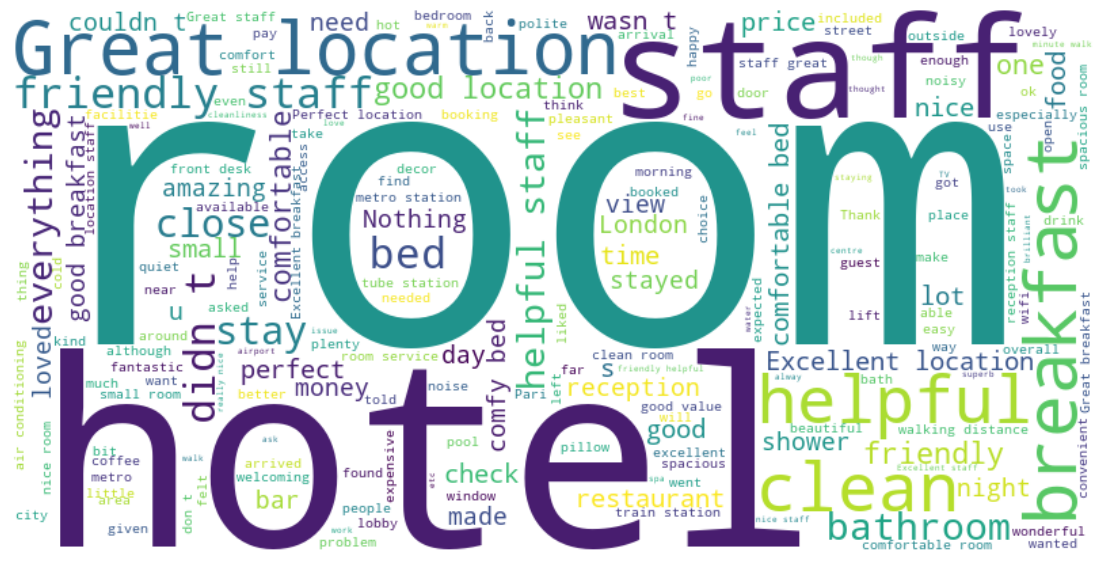

In [32]:
gen_wc(good_reviews_text)

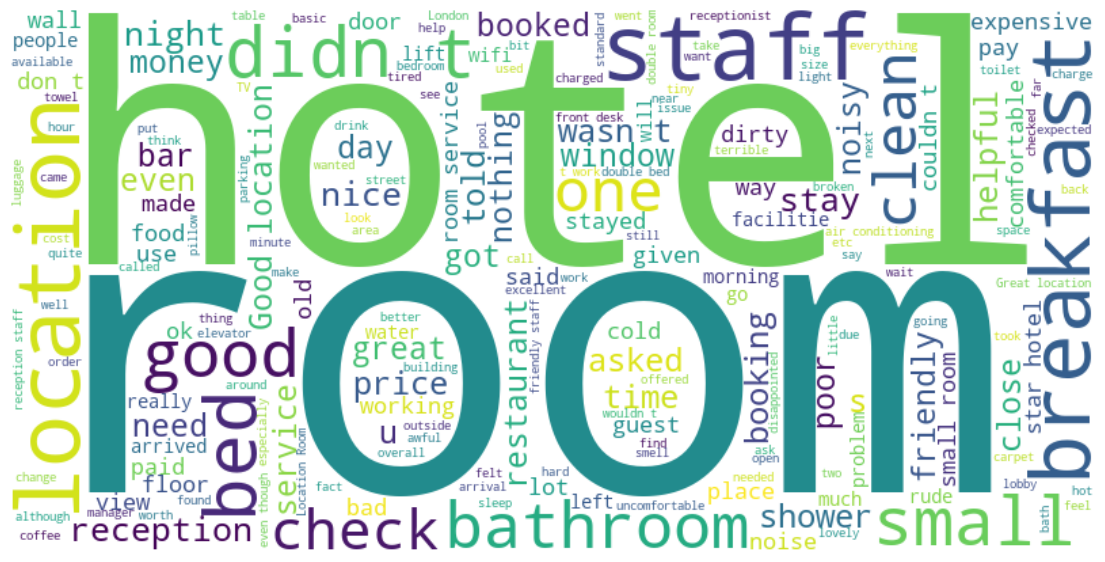

In [33]:
gen_wc(bad_reviews_text)

## Resampling

In [34]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)

df_review_resampled = pd.concat([good_df, bad_reviews], axis=0).reset_index(drop=True)
df_review_resampled.shape

(173702, 2)

In [35]:
df_review_resampled.head()

,Review,Review_type
0,Location was excellent rooms were extremely c...,good
1,very comfortable bed excellent air con great ...,good
2,The views,good
3,Clean and comfortable room Kettle and selecti...,good
4,Beds comfy staff lovely food amazing room spa...,good


Text(0.5, 1.0, 'Review type (resampled)')

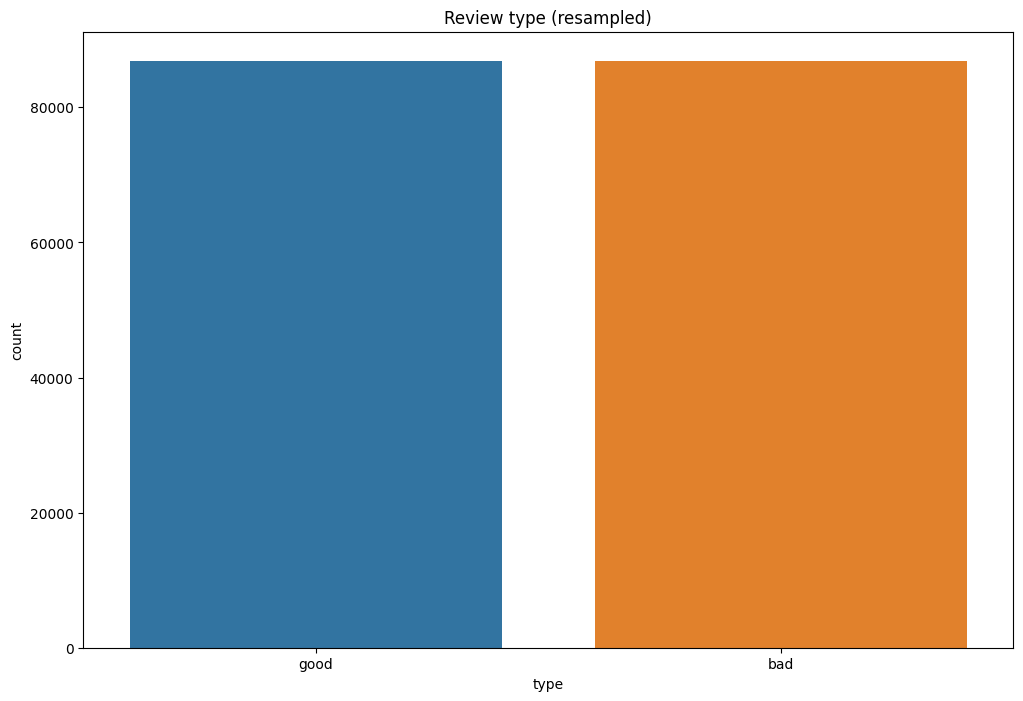

In [36]:
sns.countplot(
  x='Review_type',
  data=df_review_resampled,
  order=df_review_resampled.Review_type.value_counts().index,
)

plt.xlabel("type")
plt.title("Review type (resampled)")

# Data Preparation
---

In [37]:
label_enc = LabelEncoder()
encoded_review = label_enc.fit_transform(df_review_resampled.Review_type.values)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_review_resampled.Review, encoded_review, test_size=0.2, random_state=RANDOM_SEED)

# Modelling
---

## Feature Extraction

In [39]:
%%time
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
            stop_words = 'english')

tfv.fit(list(X_train) + list(X_test))

X_train_tfv =  tfv.transform(X_train) 
X_test_tfv = tfv.transform(X_test)

CPU times: total: 20.9 s
Wall time: 21.1 s


## Word Vectors

In [40]:
X_train_emb = []
for r in tqdm(X_train):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train_emb.append(review_emb)

100%|██████████| 138961/138961 [1:20:48<00:00, 28.66it/s]


In [41]:
X_train_emb = np.array(X_train_emb)

In [42]:
X_test_emb = []
for r in tqdm(X_test):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test_emb.append(review_emb)

X_test_emb = np.array(X_test_emb)

100%|██████████| 34741/34741 [18:58<00:00, 30.51it/s]


In [43]:
# plot accuracy and loss
def plot_history(history):
  accuracy = history.history['accuracy']
  val_accuracy= history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

## LSTM 

In [44]:
y_train.shape

(138961,)

In [45]:
X_train_reshaped = X_train_emb[:, np.newaxis,:]
X_test_reshaped = X_test_emb[:, np.newaxis,:]
y_train_reshaped = y_train[:, np.newaxis, np.newaxis]
y_test_reshaped = y_test[:, np.newaxis, np.newaxis]

In [46]:
y_train_reshaped.shape

(138961, 1, 1)

In [47]:
1, X_train_reshaped.shape[2]

(1, 512)

In [48]:
def build_model_lstm():
  model = Sequential()

  model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
  model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))

  model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

In [49]:
model_lstm = build_model_lstm()
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            787456    
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense (Dense)               (None, 1, 1)              65        
                                                                 
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model_lstm.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7817/7817 [==============================] - 134s 17ms/step - loss: 0.4316 - accuracy: 0.7936 - val_loss: 0.4168 - val_accuracy: 0.8052
Epoch 2/10
7817/7817 [==============================] - 147s 19ms/step - loss: 0.4064 - accuracy: 0.8104 - val_loss: 0.4057 - val_accuracy: 0.8116
Epoch 3/10
7817/7817 [==============================] - 146s 19ms/step - loss: 0.3936 - accuracy: 0.8181 - val_loss: 0.3993 - val_accuracy: 0.8125
Epoch 4/10
7817/7817 [==============================] - 147s 19ms/step - loss: 0.3819 - accuracy: 0.8252 - val_loss: 0.3944 - val_accuracy: 0.8182
Epoch 5/10
7817/7817 [==============================] - 145s 18ms/step - loss: 0.3719 - accuracy: 0.8314 - val_loss: 0.3942 - val_accuracy: 0.8158
Epoch 6/10
7817/7817 [==============================] - 139s 18ms/step - loss: 0.3608 - accuracy: 0.8375 - val_loss: 0.4013 - val_accuracy: 0.8136
Epoch 7/10
7817/7817 [==============================] - 83s 11ms/step - loss: 0.3491 - accuracy: 0.8434 - val_loss: 0.

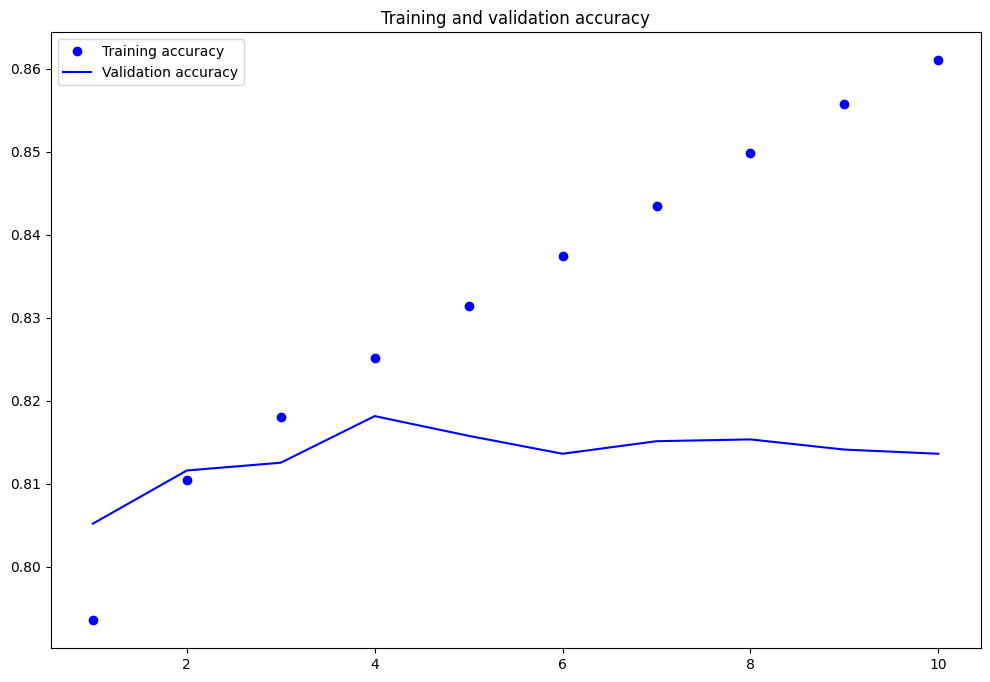

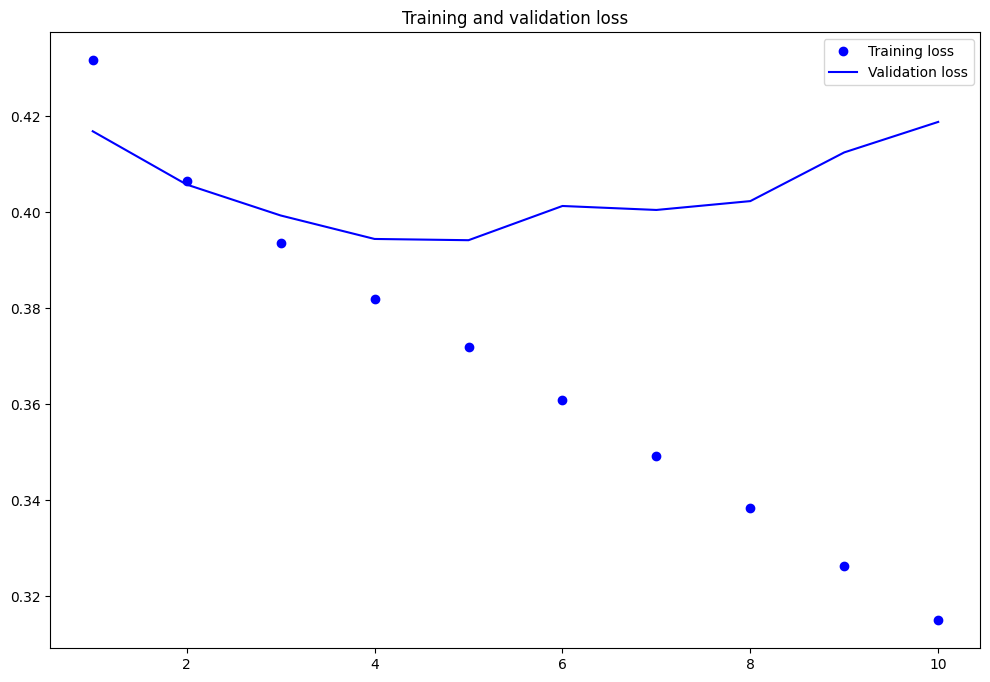

In [51]:
plot_history(history)

In [52]:
model_lstm.evaluate(X_test_reshaped, y_test_reshaped)

1086/1086 [==============================] - 14s 13ms/step - loss: 0.4286 - accuracy: 0.8106


[0.42857396602630615, 0.8105984330177307]

# Save Model
---

In [53]:
model_lstm.save("lstm_sentiment_model.h5")